In [2]:
# import libraries
import pandas as pd
from math import exp
from scipy.stats import norm
from scipy import stats
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import warnings
import statsmodels.api as sm

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils import resample

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

import xgboost as xgb
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, roc_auc_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, accuracy_score

## 1. Data Cleaning

In [6]:
county_jail_df = pd.read_csv('County_Jail.csv')
county_jail_df.head()

Unnamed: 0   reporting_jurisdictions          county_name state_name  \
0           0       Whitman County Jail       Whitman County         WA   
1           1         Adams County Jail         Adams County         WA   
2           2       Clallam County Jail       Clallam County         WA   
3           3  Ferry County Corrections         Ferry County         WA   
4           4  Grays Harbor County Jail  Grays Harbor County         WA   

         Date  jail_population  
0  2020-06-12               26  
1  2020-06-12               22  
2  2020-06-12               74  
3  2020-06-12                8  
4  2020-06-12              172

In [4]:
county_jail_df.shape

(53, 6)

In [7]:
vera_df = pd.read_csv('https://raw.githubusercontent.com/vera-institute/jail-population-data/master/jail_population.csv')
vera_df.head()

fips        date  jail_population     county_name state_name urbanicity  \
0  1001  2020-01-01              185  Autauga County    Alabama  small/mid   
1  1001  2020-01-02              184  Autauga County    Alabama  small/mid   
2  1001  2020-01-03              178  Autauga County    Alabama  small/mid   
3  1001  2020-01-04              177  Autauga County    Alabama  small/mid   
4  1001  2020-01-05              183  Autauga County    Alabama  small/mid   

  reporting_jurisdictions  resident_population  \
0      Autauga Metro Jail              55869.0   
1      Autauga Metro Jail              55869.0   
2      Autauga Metro Jail              55869.0   
3      Autauga Metro Jail              55869.0   
4      Autauga Metro Jail              55869.0   

   jail_incarceration_rate_per_100k  
0                             331.1  
1                             329.3  
2                             318.6  
3                             316.8  
4                             327.6

In [20]:
hist_vera_df=pd.read_csv('https://raw.githubusercontent.com/vera-institute/incarceration_trends/master/incarceration_trends.csv')
hist_vera_df.head()

yfips  year  fips state     county_name  total_pop  total_pop_15to64  \
0  197001001  1970  1001    AL  Autauga County      24661             14154   
1  197101001  1971  1001    AL  Autauga County      25503             14765   
2  197201001  1972  1001    AL  Autauga County      27156             15939   
3  197301001  1973  1001    AL  Autauga County      28453             16906   
4  197401001  1974  1001    AL  Autauga County      29261             17578   

   female_pop_15to64  male_pop_15to64  aapi_pop_15to64  ...  \
0               7293             6861              NaN  ...   
1               7585             7180              NaN  ...   
2               8168             7771              NaN  ...   
3               8651             8255              NaN  ...   
4               8992             8586              NaN  ...   

   native_prison_pop_rate  white_prison_pop_rate  total_prison_adm_rate  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   

   female_prison_adm_rate male_prison_adm_rate aapi_prison_adm_rate  \
0                     NaN                  NaN                  NaN   
1                     NaN                  NaN                  NaN   
2                     NaN                  NaN                  NaN   
3                     NaN                  NaN                  NaN   
4                     NaN                  NaN                  NaN   

  black_prison_adm_rate  latinx_prison_adm_rate  native_prison_adm_rate  \
0                   NaN                     NaN                     NaN   
1                   NaN                     NaN                     NaN   
2                   NaN                     NaN                     NaN   
3                   NaN                     NaN                     NaN   
4                   NaN                     NaN                     NaN   

   white_prison_adm_rate  
0                    NaN  
1                    NaN  
2                    NaN  
3                    NaN  
4                    NaN  

[5 rows x 121 columns]

In [21]:
hist_vera_df.shape

(150672, 121)

In [18]:
death_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv')
death_df.head(10)

UID iso2 iso3  code3    FIPS   Admin2            Province_State  \
0        16   AS  ASM     16    60.0      NaN            American Samoa   
1       316   GU  GUM    316    66.0      NaN                      Guam   
2       580   MP  MNP    580    69.0      NaN  Northern Mariana Islands   
3       630   PR  PRI    630    72.0      NaN               Puerto Rico   
4       850   VI  VIR    850    78.0      NaN            Virgin Islands   
5  84001001   US  USA    840  1001.0  Autauga                   Alabama   
6  84001003   US  USA    840  1003.0  Baldwin                   Alabama   
7  84001005   US  USA    840  1005.0  Barbour                   Alabama   
8  84001007   US  USA    840  1007.0     Bibb                   Alabama   
9  84001009   US  USA    840  1009.0   Blount                   Alabama   

  Country_Region        Lat       Long_  ... 6/8/20  6/9/20  6/10/20  6/11/20  \
0             US -14.271000 -170.132000  ...      0       0        0        0   
1             US  13.444300  144.793700  ...      5       5        5        5   
2             US  15.097900  145.673900  ...      2       2        2        2   
3             US  18.220800  -66.590100  ...    142     142      143      144   
4             US  18.335800  -64.896300  ...      6       6        6        6   
5             US  32.539527  -86.644082  ...      5       5        6        6   
6             US  30.727750  -87.722071  ...      9       9        9        9   
7             US  31.868263  -85.387129  ...      1       1        1        1   
8             US  32.996421  -87.125115  ...      1       1        1        1   
9             US  33.982109  -86.567906  ...      1       1        1        1   

   6/12/20  6/13/20  6/14/20  6/15/20  6/16/20  6/17/20  
0        0        0        0        0        0        0  
1        5        5        5        5        5        5  
2        2        2        2        2        2        2  
3      146      146      147      147      147      147  
4        6        6        6        6        6        6  
5        6        6        6        6        6        6  
6        9        9        9        9        9        9  
7        1        1        1        1        1        1  
8        1        1        1        1        1        1  
9        1        1        1        1        1        1  

[10 rows x 160 columns]

In [15]:
death_df

iso3  code3  FIPS            Province_State Country_Region        Lat  \
0     ASM     16  60.0            American Samoa             US -14.271000   
1     GUM    316  66.0                      Guam             US  13.444300   
2     MNP    580  69.0  Northern Mariana Islands             US  15.097900   
3     PRI    630  72.0               Puerto Rico             US  18.220800   
4     VIR    850  78.0            Virgin Islands             US  18.335800   
...   ...    ...   ...                       ...            ...        ...   
3256  USA    840   NaN                      Utah             US  39.372319   
3257  USA    840   NaN                      Utah             US  38.996171   
3258  USA    840   NaN                      Utah             US  37.854472   
3259  USA    840   NaN                      Utah             US  40.124915   
3260  USA    840   NaN                      Utah             US  41.271160   

           Long_                  Combined_Key  Population  1/22/20  ...  \
0    -170.132000            American Samoa, US       55641        0  ...   
1     144.793700                      Guam, US      164229        0  ...   
2     145.673900  Northern Mariana Islands, US       55144        0  ...   
3     -66.590100               Puerto Rico, US     2933408        0  ...   
4     -64.896300            Virgin Islands, US      107268        0  ...   
...          ...                           ...         ...      ...  ...   
3256 -111.575868        Central Utah, Utah, US           0        0  ...   
3257 -110.701396      Southeast Utah, Utah, US           0        0  ...   
3258 -111.441876      Southwest Utah, Utah, US           0        0  ...   
3259 -109.517442           TriCounty, Utah, US           0        0  ...   
3260 -111.914512        Weber-Morgan, Utah, US           0        0  ...   

      6/8/20  6/9/20  6/10/20  6/11/20  6/12/20  6/13/20  6/14/20  6/15/20  \
0          0       0        0        0        0        0        0        0   
1          5       5        5        5        5        5        5        5   
2          2       2        2        2        2        2        2        2   
3        142     142      143      144      146      146      147      147   
4          6       6        6        6        6        6        6        6   
...      ...     ...      ...      ...      ...      ...      ...      ...   
3256       0       0        0        0        0        0        0        0   
3257       0       0        0        0        0        0        0        0   
3258       4       4        4        4        5        5        5        7   
3259       0       0        0        0        0        0        0        0   
3260       8       8        8        8        9        9        9        9   

      6/16/20  6/17/20  
0           0        0  
1           5        5  
2           2        2  
3         147      147  
4           6        6  
...       ...      ...  
3256        0        0  
3257        0        0  
3258        7        8  
3259        0        0  
3260        9        9  

[3261 rows x 157 columns]

In [3]:
df.drop(columns = ['ID'], inplace = True)
df.rename(columns = {'default payment next month':'DEFAULT'}, inplace = True) 

## 2. EDA

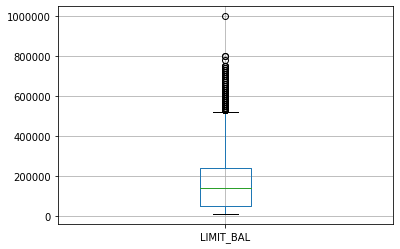

In [4]:
df.boxplot('LIMIT_BAL')

In [5]:
df.loc[df['LIMIT_BAL']>900000]
df.drop(index=[13774], inplace=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24]),
 <a list of 24 Text xticklabel objects>)

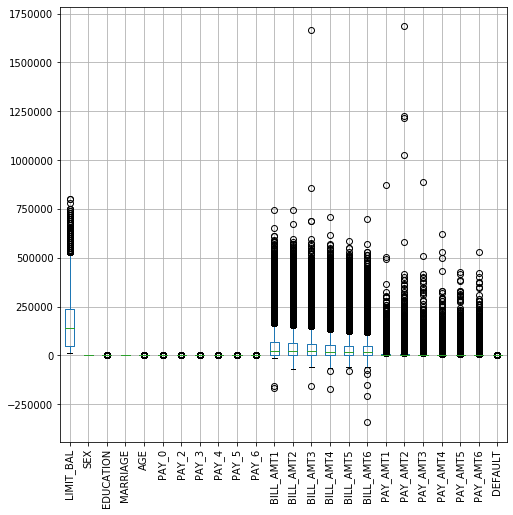

In [6]:
pd.DataFrame.boxplot(df,figsize=(8,8))
plt.xticks(rotation=90)

## 3. Feature Engineering

In [7]:
education_dummies = pd.get_dummies(df['EDUCATION'], prefix='education')
marriage_dummies = pd.get_dummies(df['MARRIAGE'], prefix='marriage')
df = pd.concat([df, education_dummies, marriage_dummies], axis=1)
df.drop(columns = ['EDUCATION','MARRIAGE'], inplace = True)
df.columns

Index(['LIMIT_BAL', 'SEX', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
       'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'DEFAULT', 'education_0',
       'education_1', 'education_2', 'education_3', 'education_4',
       'education_5', 'education_6', 'marriage_0', 'marriage_1', 'marriage_2',
       'marriage_3'],
      dtype='object')

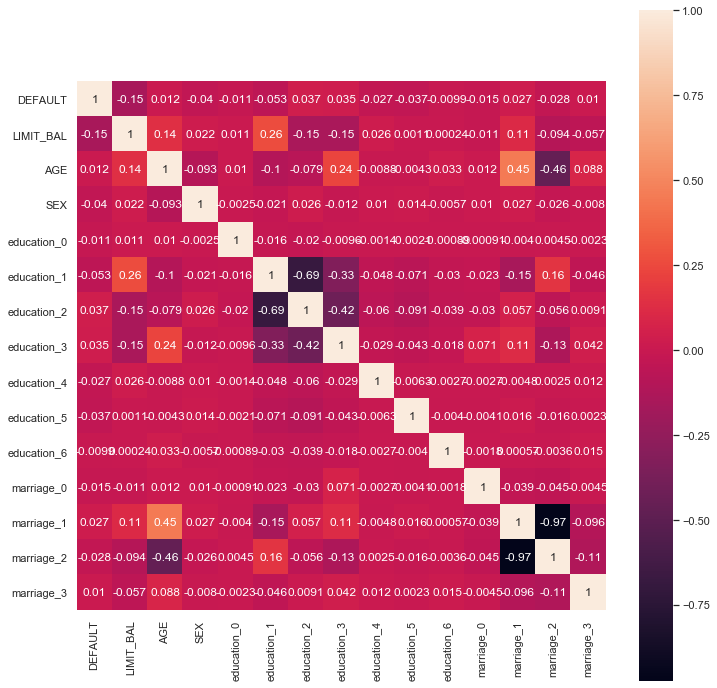

In [8]:
corrmat = df[['DEFAULT','LIMIT_BAL', 'AGE','SEX', 'education_0', 'education_1', 'education_2',
       'education_3', 'education_4', 'education_5', 'education_6',
       'marriage_0', 'marriage_1', 'marriage_2', 'marriage_3']].corr()

sns.set(font_scale=1)
fig,ax= plt.subplots()
fig.set_size_inches(10,10)
plt.tight_layout()
sns.heatmap(corrmat,square=True,annot=True, cbar = True)

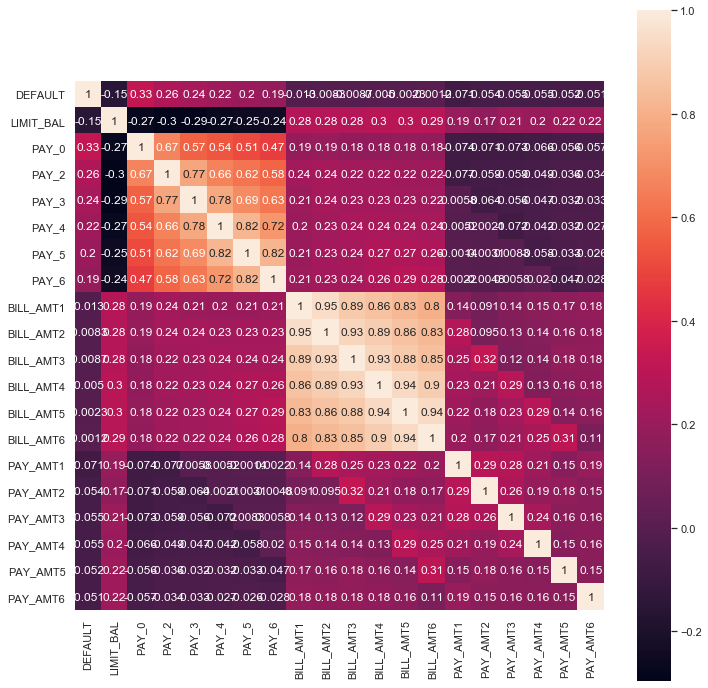

In [9]:
corrmat = df[['DEFAULT','LIMIT_BAL', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',\
              'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', \
              'BILL_AMT6', 'PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',\
              'PAY_AMT6']].corr()
sns.set(font_scale=1)
fig,ax= plt.subplots()
fig.set_size_inches(10,10)
plt.tight_layout()
sns.heatmap(corrmat,square=True,annot=True, cbar = True)

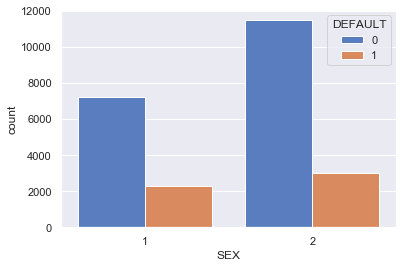

In [10]:
sns.countplot(x="SEX", data=df,hue="DEFAULT", palette="muted")

In [11]:
# df.PAY_0 = np.where(df.PAY_0 < 1 , 0, df.PAY_0)
# df.PAY_0 = np.where(df.PAY_0 >=1 , 1, df.PAY_0)

# df.PAY_2 = np.where(df.PAY_2 < 1 , 0, df.PAY_0)
# df.PAY_2 = np.where(df.PAY_2 >=1 , 1, df.PAY_0)

# df.PAY_3 = np.where(df.PAY_3 < 1 , 0, df.PAY_0)
# df.PAY_3 = np.where(df.PAY_3 >=1 , 1, df.PAY_0)

# df.PAY_4 = np.where(df.PAY_4 < 1 , 0, df.PAY_0)
# df.PAY_4 = np.where(df.PAY_4 >=1 , 1, df.PAY_0)

# df.PAY_5 = np.where(df.PAY_5 < 1 , 0, df.PAY_0)
# df.PAY_5 = np.where(df.PAY_5 >=1 , 1, df.PAY_0)

# df.PAY_6 = np.where(df.PAY_6 < 1 , 0, df.PAY_0)
# df.PAY_6 = np.where(df.PAY_6 >=1 , 1, df.PAY_0)

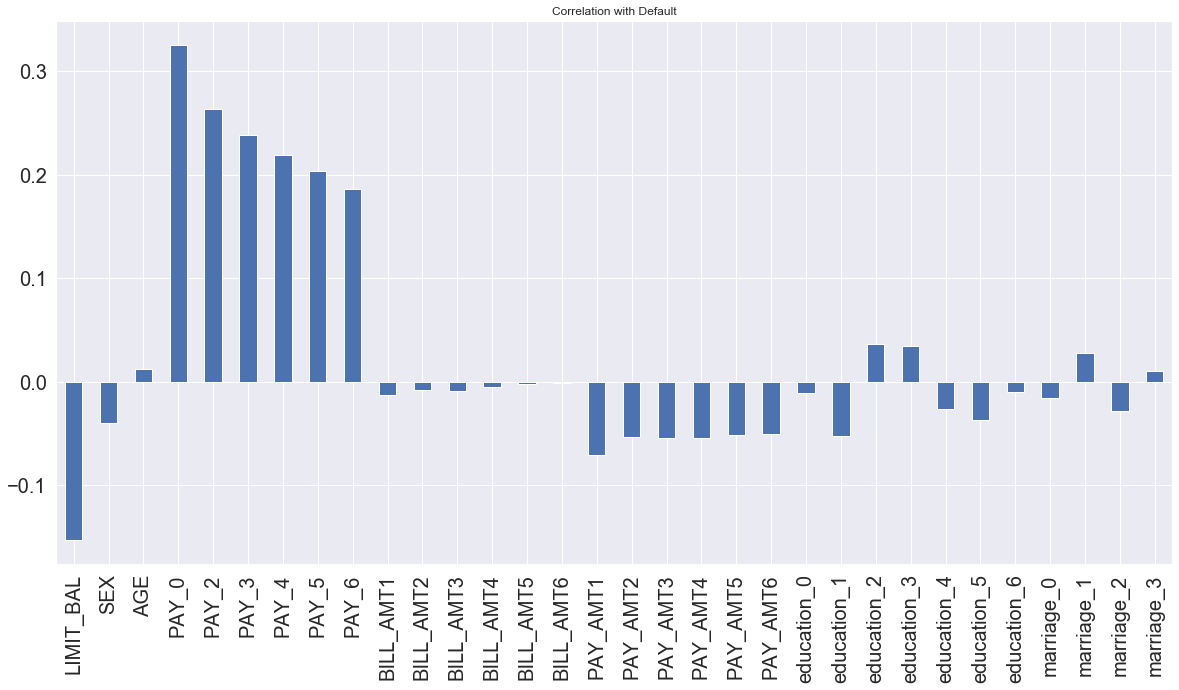

In [12]:
X = df.drop(['DEFAULT'],axis=1)
y = df['DEFAULT']

X.corrwith(df['DEFAULT']).plot.bar(
        figsize = (20, 10), title = "Correlation with Default", fontsize = 20,
        rot = 90, grid = True)

## 4. Feature Selection

In [13]:
# recursive feature selection

In [14]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
       'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'DEFAULT', 'education_0',
       'education_1', 'education_2', 'education_3', 'education_4',
       'education_5', 'education_6', 'marriage_0', 'marriage_1', 'marriage_2',
       'marriage_3'],
      dtype='object')

In [15]:
features=df[['LIMIT_BAL', 'SEX', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
       'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'education_0',
       'education_1', 'education_2', 'education_3', 'education_4',
       'education_5', 'education_6', 'marriage_0', 'marriage_1', 'marriage_2',
       'marriage_3']]

In [16]:
# min_train = X_train.min()
# range_train = (X_train - min_train).max()
# X_train_scaled = (X_train - min_train)/range_train

In [17]:
# min_test = X_test.min()
# range_test = (X_test - min_test).max()
# X_test_scaled = (X_test - min_test)/range_test

## 5. Model Fitting and Hyperparameter Tuning
KNN, Logistic Regression, Decision Tree

In [18]:
X = df.drop('DEFAULT', axis = 1)
y = df['DEFAULT']
feature_cols = X.columns

In [19]:
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Logistic Regression

In [20]:
# Create intercept term
X = sm.add_constant(X)

# Fit model
logit_model = sm.Logit(y, X)

# Get results of the fit
result = logit_model.fit()

         Current function value: 0.464375
         Iterations: 35


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [21]:
logreg = LogisticRegression(fit_intercept = False, C = 1e15, solver='liblinear')
model_log = logreg.fit(X, y)
model_log

LogisticRegression(C=1000000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

### KNN

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [23]:
scaler = StandardScaler()  
scaler.fit(X_train)

X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test) 

In [24]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
print(knn)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')


In [25]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [26]:
# make class predictions for the testing set
y_pred_class = knn.predict(X_test)

In [27]:
# calculate accuracy
print('Accuracy:' + str(metrics.accuracy_score(y_test, y_pred_class)))
print('F1:' + str(metrics.f1_score(y_test, y_pred_class)))

Accuracy:0.7316666666666667
F1:0.37402799377916013


## Final Model: XGBoost

In [28]:
df['DEFAULT'].value_counts()

0    18690
1     5308
Name: DEFAULT, dtype: int64

In [29]:
X = df.drop('DEFAULT', axis = 1)
y = df['DEFAULT']
feature_cols = X.columns

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23)

In [31]:
training = pd.concat([X_train,y_train], axis =1)

In [32]:
ndefault = training[training['DEFAULT']==0]
default = training[training['DEFAULT']==1]

In [33]:
upsampled = resample(default,
                          replace=True, # sample with replacement
                          n_samples=len(ndefault), # match number in majority class
                          random_state=23) # reproducible results

upsampled = pd.concat([ndefault, upsampled])
upsampled['DEFAULT'].value_counts()

1    14032
0    14032
Name: DEFAULT, dtype: int64

In [34]:
upsampled

LIMIT_BAL  SEX  AGE  PAY_0  PAY_2  PAY_3  PAY_4  PAY_5  PAY_6  \
18610     380000    2   33      1      1      2      2      2      2   
15020     250000    2   29      0      0      0      0      0      0   
15875     120000    2   37     -2     -2     -2     -2     -2     -1   
13456     490000    1   41      1      2      0      0      0      0   
1891      320000    2   47     -1     -1      2     -1      2     -1   
...          ...  ...  ...    ...    ...    ...    ...    ...    ...   
20292      60000    1   36     -1      2      2     -1     -1     -2   
21411      50000    2   31      0      0      0      2      0      0   
20147      20000    1   48     -1      0     -1     -1      2      0   
19840     330000    2   27      0      0      0      0      2      2   
22863      20000    2   27      0      0      0      0     -1     -1   

       BILL_AMT1  ...  education_2  education_3  education_4  education_5  \
18610     363944  ...            1            0            0            0   
15020     180056  ...            1            0            0            0   
15875        874  ...            1            0            0            0   
13456     230090  ...            0            0            0            0   
1891       10159  ...            1            0            0            0   
...          ...  ...          ...          ...          ...          ...   
20292        780  ...            0            0            0            0   
21411      45074  ...            1            0            0            0   
20147       1522  ...            0            1            0            0   
19840     322464  ...            0            0            0            0   
22863      10489  ...            1            0            0            0   

       education_6  marriage_0  marriage_1  marriage_2  marriage_3  DEFAULT  
18610            0           0           1           0           0        0  
15020            0           0           1           0           0        0  
15875            0           0           0           1           0        0  
13456            0           0           1           0           0        0  
1891             0           0           1           0           0        0  
...            ...         ...         ...         ...         ...      ...  
20292            0           0           0           1           0        1  
21411            0           0           1           0           0        1  
20147            0           0           1           0           0        1  
19840            0           0           0           1           0        1  
22863            0           0           1           0           0        1  

[28064 rows x 33 columns]

In [35]:
# ndefault = df[df['DEFAULT']==0]
# default = df[df['DEFAULT']==1]

# upsampled = resample(default,
#                           replace=True, # sample with replacement
#                           n_samples=len(ndefault), # match number in majority class
#                           random_state=23) # reproducible results

# upsampled = pd.concat([ndefault, upsampled])
# upsampled['DEFAULT'].value_counts()

In [36]:
X_train = upsampled.drop('DEFAULT', axis = 1)
y_train = upsampled['DEFAULT']
feature_cols = X_train.columns

In [37]:
X_train.columns

Index(['LIMIT_BAL', 'SEX', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
       'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'education_0', 'education_1',
       'education_2', 'education_3', 'education_4', 'education_5',
       'education_6', 'marriage_0', 'marriage_1', 'marriage_2', 'marriage_3'],
      dtype='object')

In [38]:
xgb.XGBClassifier()
xg_clf = xgb.XGBClassifier(objective ='binary:logistic', 
                           colsample_bytree = 0.3, 
                           subsample = 0.5,
                           learning_rate = 0.1,
                           max_depth = 4, 
                           alpha = 1, 
                           n_estimators = 10000)
xg_clf.fit(X_train,y_train)
preds = xg_clf.predict(X_test)

test_f1 = f1_score(y_test, preds)
test_acc = accuracy_score(y_test, preds)

print("Accuracy: %f" % (test_acc))
print("F1: %f" % (test_f1))

Accuracy: 0.777500
F1: 0.466214


## TEST

In [39]:
test = pd.read_csv('hold_out_features.csv')

In [40]:
test.head()

Unnamed: 0     ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  \
0           0   6320     240000    1          1         1   44     -1     -1   
1           1  29659      50000    1          3         1   41      0      0   
2           2  28347      20000    2          3         1   41      0      0   
3           3   8523     320000    2          1         2   34     -2     -2   
4           4  22135     120000    2          2         1   23      0      0   

   PAY_3  ...  BILL_AMT3  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  \
0     -1  ...       2701       2427       1104       2362      2188      2701   
1      0  ...      48468      39203      28913      26636      1816      1753   
2      0  ...      11583      13079      14546      16149      2000      1600   
3     -2  ...       -528      -1336      -1336      -1336         0         4   
4      0  ...      66825      68820      69776      71297      3000      2500   

   PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  
0      2427      1104      2362       519  
1      1433       990       967      1071  
2      2000      2000      2000      2000  
3         0         0         0         0  
4      3100      2700      2800      2800  

[5 rows x 25 columns]

In [41]:
test.drop(columns = ['Unnamed: 0'], inplace = True)

In [42]:
education_dummies = pd.get_dummies(test['EDUCATION'], prefix='education')
marriage_dummies = pd.get_dummies(test['MARRIAGE'], prefix='marriage')
test = pd.concat([test, education_dummies, marriage_dummies], axis=1)
test.drop(columns = ['EDUCATION','MARRIAGE'], inplace = True)
test.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4',
       'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'education_0', 'education_1',
       'education_2', 'education_3', 'education_4', 'education_5',
       'education_6', 'marriage_0', 'marriage_1', 'marriage_2', 'marriage_3'],
      dtype='object')

In [43]:
final_results=xg_clf.predict(test)

ValueError: feature_names mismatch: ['LIMIT_BAL', 'SEX', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'education_0', 'education_1', 'education_2', 'education_3', 'education_4', 'education_5', 'education_6', 'marriage_0', 'marriage_1', 'marriage_2', 'marriage_3'] ['ID', 'LIMIT_BAL', 'SEX', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'education_0', 'education_1', 'education_2', 'education_3', 'education_4', 'education_5', 'education_6', 'marriage_0', 'marriage_1', 'marriage_2', 'marriage_3']
training data did not have the following fields: ID

In [ ]:
final_results=pd.Series(final_results)
final_results.to_csv('MR.csv', index=False)

In [ ]:
final_results.value_counts()

In [ ]:
# import pickle

# with open('MandR_Pickle.pickle','wb') as f:
#     pickle.dump(xg_clf, f)

### Notes: clean-up code for the project

In [ ]:
# def fit_predict(model1, x_train, y_train, test):
#     model.fit(x_train, y_train)
#     predictions = model.predict(test)
# print('Test Accuracy Score', accuracy_score(test, prediction))
# print('F1 Score', f1_score(test, prediction))
# return